In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

In [20]:
import numpy as np
from itertools import *

In [3]:
real_dtype = tf.float64
cmplx_dtype = tf.complex128

In [173]:
def squared_L2_norm(x):
    """
    Squared L2 norm
    """
    if x.dtype in [tf.float64, tf.float32, tf.float16]:
        return tf.reduce_sum(tf.multiply(x, x))
    elif x.dtype in [tf.complex128, tf.complex64]:
        return tf.reduce_sum(tf.real(tf.multiply(tf.conj(x), x)))
    else:
        raise RuntimeError("Unknown type: " + x.dtype)
    
class CPModel(object):
  """
  minimize |y - A * x|_2^2 + alpha * |x|_2^2
  """
  def __init__(self, A, y, alpha, D):
    N1 = A.shape[0]
    self.right_dims = A.shape[1:]
    self.right_dim = len(right_dims)
    assert y.shape == tf.TensorShape([N1])
    
    def create_tensor(N, M):
        rand = np.random.rand(N, M) + 1J * np.random.rand(N, M)
        return tf.Variable(rand, dtype=cmplx_dtype)
    
    self.y = y
    self.A = A
    self.alpha = alpha
    self.D = D
    self.x_tensors = [create_tensor(D, right_dims[i]) for i in range(self.right_dim)]
    #self.x = tf.Variable(np.zeros(), dtype=real_dtype)

  def var_list(self):
    """
    Return a list of model parameters
    """
    return self.x_tensors

  def full_tensor_x(self):
    """
    Construct a full tensor representation of parameters
    
    sum_d T(d,i) * T(d,j) * T(d,k) * ...
    
    We construct the tensors as follows:
        T(d, i) -> tildeT(d, i)
        tildeT(d,i) * T(d,j) -> tildeT(d, i, j)
        tildeT(d, i, j) * T(d, k) -> tildeT(d, i, j, k)
        
    """
    tildeT = self.x_tensors[0]
    for i in range(1, self.right_dim):
        tildeT_reshaped = tf.reshape(tildeT, (D,-1))
        tildeT = tf.einsum('dI,di->dIi', tildeT_reshaped, self.x_tensors[i])
    full_tensor = tf.reduce_sum(tf.reshape(tildeT, (D,) + tuple(right_dims)), axis=0)
    assert full_tensor.shape == tf.TensorShape(right_dims)
    return full_tensor

  def predict_y(self):
    """
    Predict y from self.x_tensors
    
    sum_d sum_{ijk...} A(n,ijk...) * T(d,i) * T(d,j) * T(d,k) * ...
    """
    tildeA = tf.einsum('nij,di->njd', tf.reshape(self.A, (N1, right_dims[0], -1)), self.x_tensors[0])
    for i in range(1, self.right_dim):
        tilde_right_dims = self.right_dims[i:]
        tildeA_reshaped = tf.reshape(tildeA, (N1,) + (self.right_dims[i],) + (-1, self.D,))
        tildeA = tf.einsum('nijd,di->njd', tildeA_reshaped, self.x_tensors[i])
    
    assert tildeA.shape == tf.TensorShape([N1, 1, D])
    return tf.reduce_sum(tf.reshape(tildeA, [N1,D]), axis=1)

  def loss(self):
    """
    Compute mean squared error + L2 regularization term
    """
    y_pre = self.predict_y()
    assert self.y.shape == y_pre.shape
    return (squared_L2_norm(self.y - y_pre) + alpha * squared_L2_norm(self.full_tensor_x()))/N1

In [196]:
N1 = 2
right_dims = (1, 2, 3)
np.random.seed(100)

A = tf.constant(1J * np.random.randn(N1 * np.product(right_dims)).reshape((N1,) + right_dims), dtype=cmplx_dtype)
y = tf.constant(np.random.randn(N1), dtype=cmplx_dtype)

In [197]:
alpha = 0.0
D = 10
model = CPModel(A, y, alpha, D)
print("current loss: ", model.loss())

current loss:  tf.Tensor(6.25897852137396, shape=(), dtype=float64)


In [198]:
learning_rate = 0.01

def loss_f():
    loss = model.loss()
    losss.append(loss)
    return loss

losss = []
diff_losss = []
epochs = range(1000)
tol_rmse = 1e-12
for epoch in epochs:
  with tf.GradientTape() as tape:
      loss = loss_f()
  grads = tape.gradient(loss, model.var_list())
  
  # Update parameters
  var_list = model.var_list()
  for i in range(len(var_list)):
        var_list[i].assign_sub(learning_rate * grads[i])
    
  if len(losss) > 2:
     diff_losss.append(np.abs(losss[-2] - losss[-1]))
     if losss[-1] < tol_rmse**2 or np.abs(losss[-2] - losss[-1]) < tol_rmse**2:
         break
    

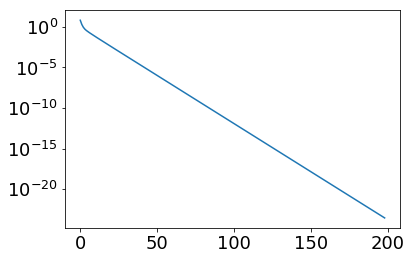

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs[:len(losss)], losss)
plt.yscale("log")

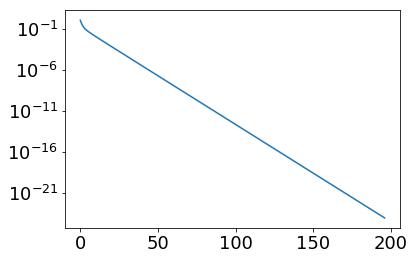

In [200]:
plt.semilogy(diff_losss)

In [201]:
model.full_tensor_x().numpy()

array([[[-2.77804109+2.96526526j, -1.16348313+1.80668804j,
         -2.08775301+2.41566262j],
        [-2.3477418 +2.33829092j, -1.40716313+1.69280929j,
         -2.46342538+2.52175063j]]])

In [206]:
x = model.full_tensor_x().numpy().reshape(np.prod(right_dims))
Amat = A.numpy().reshape((N1, np.prod(right_dims)))
y_fit = Amat @ x
print(y)
print(Amat)
print(x)

tf.Tensor([-0.58359505+0.j  0.81684707+0.j], shape=(2,), dtype=complex128)
[[-0.-1.74976547j  0.+0.3426804j   0.+1.1530358j  -0.-0.25243604j
   0.+0.98132079j  0.+0.51421884j]
 [ 0.+0.22117967j -0.-1.07004333j -0.-0.18949583j  0.+0.25500144j
  -0.-0.45802699j  0.+0.43516349j]]
[-2.77804109+2.96526526j -1.16348313+1.80668804j -2.08775301+2.41566262j
 -2.3477418 +2.33829092j -1.40716313+1.69280929j -2.46342538+2.52175063j]


In [203]:
y - y_fit

<tf.Tensor: id=4335083, shape=(2,), dtype=complex128, numpy=array([-3.13749027e-13-2.63788991e-13j, -1.50823798e-12-1.36624045e-12j])>